In [1]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-balance/build/python')

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt, Bool

mi.set_variant('cuda_ad_rgb')

In [2]:
# !python3 /home/jonathan/Documents/mi3-balance/scripts/resources/cbox-tessellated/generate_cbox.py 3

In [3]:
scene = mi.load_file("/home/jonathan/Documents/mi3-balance/scripts/resources/cbox-tessellated/cbox-disney-rough-spec.xml")

In [4]:
from emitter_sampling import RadianceCacheEM

radiance_cache_exact = RadianceCacheEM(scene, 256, 128)

Fitting spherical harmonics to scene...


100%|██████████| 8/8 [00:01<00:00,  7.35it/s]

Fitting complete.


In [5]:
colors = {
    'white': [0.9, 0.7, 0.6],
    'box': [0.5, 0.3, 0.9],
    'red': [0.6, 0.1, 0.1],
    'green': [0.1, 0.4, 0.1],
    'light': [0.9, 0.7, 0.7]
}

roughs = {
    'white': 0.5,
    'box': 0.6,
    'red': 0.85,
    'green': 0.7,
    'light': 0.5
}

mesh_materials = ['white', 'white', 'white', 'green', 'red', 'box', 'box', 'light']

In [6]:
from vertex_bsdf import Principled

bsdf_train = Principled(specular = 0.5, has_metallic = False)

for mesh_idx, (mesh, material) in enumerate(zip(scene.shapes(), mesh_materials)):
    if not(mesh.is_mesh()):
        continue
    bsdf_train.initialize_mesh_attributes(mesh, [0.5, 0.5, 0.5], m_roughness = 0.9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.7305355].


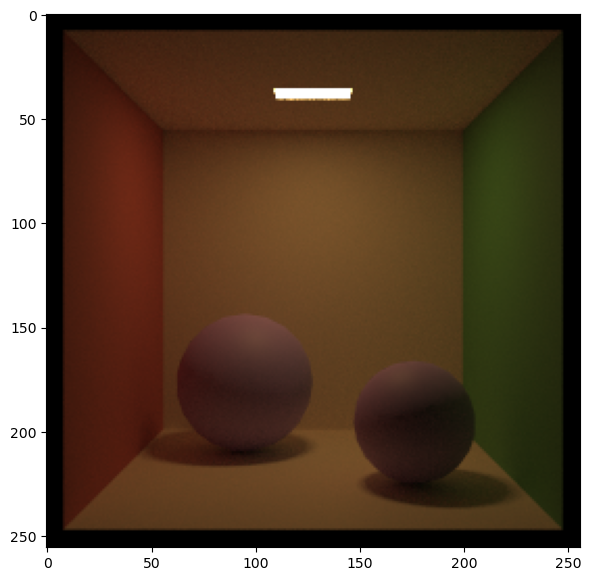

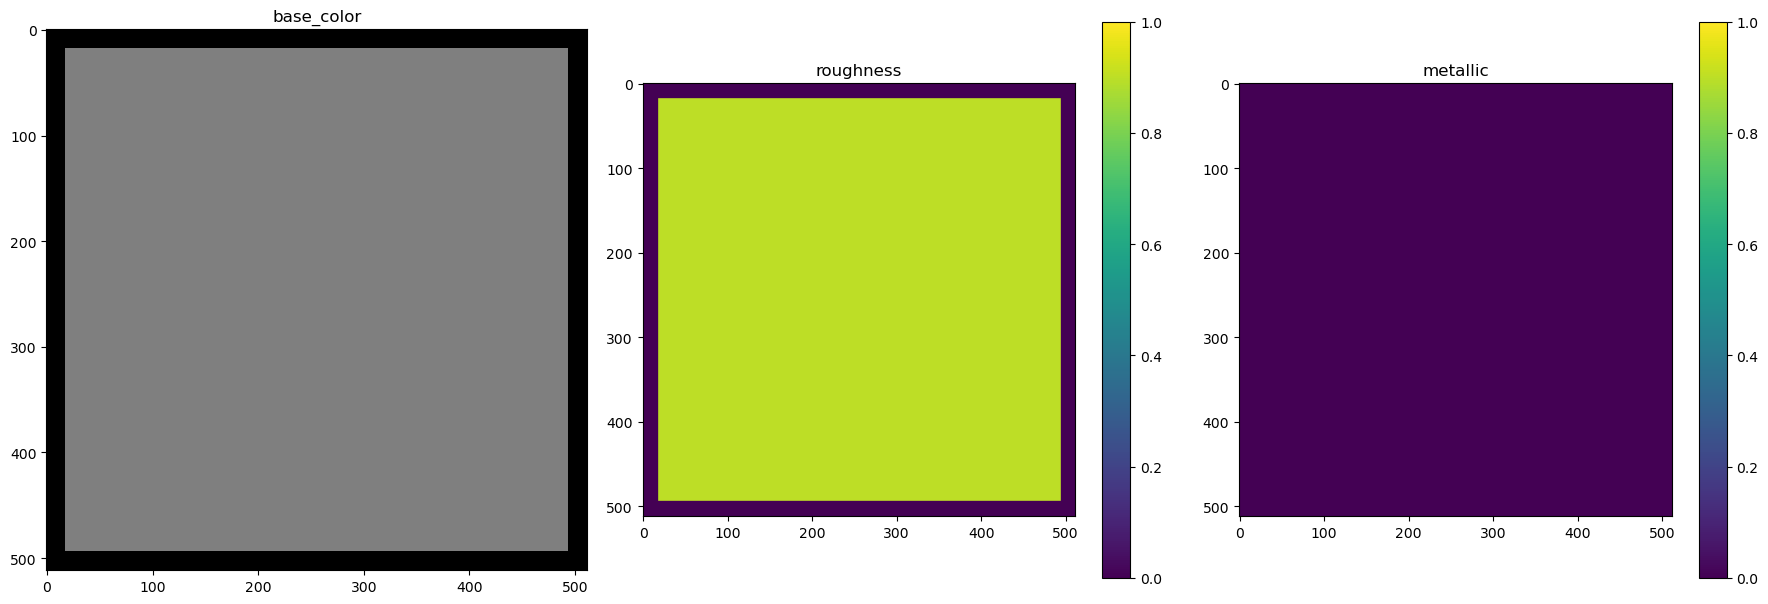

In [7]:
from bsdf_utils import render_attributes, render_attributes_gt, ps_visualize_textures

# ps_visualize_textures(scene)

import matplotlib.pyplot as plt
import numpy as np

out = render_attributes(scene, (512, 512), False)

# Scene render
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(mi.render(scene) ** (1.0 / 2.2)); plt.tight_layout()

# BSDF initial values
plt.figure(figsize=(18,6), dpi=100)
plt.subplot(131); plt.imshow(out[:,:,:3]); plt.title("base_color")
plt.subplot(132); plt.imshow(out[:,:,3], vmin=0.0, vmax=1.0); plt.title("roughness"); plt.colorbar()
plt.subplot(133); plt.imshow(out[:,:,4], vmin=0.0, vmax=1.0); plt.title("metallic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,5], vmin=0.0, vmax=1.0); plt.title("anisotropic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,6], vmin=0.0, vmax=1.0); plt.title("spec_tint");  plt.colorbar()
plt.tight_layout()

In [8]:
NUM_GEO_SAMPLES = 1 << 10 # 10
NUM_WI_DIRECTIONS = 256 << 0

%load_ext autoreload
%autoreload 2

In [9]:
from emitter_sampling import compute_loss
from radiosity_sh import SceneSurfaceSampler
from regularizer import TVRegularizer
from time import time

params = mi.traverse(scene)
keys = [key for key in params.keys() if "vertex_bsdf" in key]
opt = mi.ad.Adam(lr=0.05)
for key in keys:
    dr.enable_grad(params[key])
    opt[key] = params[key]
    params.update(opt)

scene_sampler = SceneSurfaceSampler(scene, method='equiarea')
regularizer = TVRegularizer(scene)

losses = []
for it in range(150):
    if it % 50 == 0:
        render_attributes(scene, (512, 512), True, f"output/itr={it}")

    time1 = time()

    # Evaluate the objective function for the current BSDF params
    loss = compute_loss(scene_sampler, radiance_cache_exact, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, num_wo = 8, rng_state = it)
    
    with dr.resume_grad():
        loss += 3e-4 * regularizer.compute_loss(scene, ['vertex_bsdf_roughness'])

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    for key in keys:
        opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    losses.append(loss.numpy())
    time2 = time()
    print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}")

Iteration 001 [1.204377]: Loss = [0.000899634]
Iteration 002 [0.272845]: Loss = [0.000667702]
Iteration 003 [0.268091]: Loss = [0.000506923]
Iteration 004 [0.265915]: Loss = [0.000382552]
Iteration 005 [0.262930]: Loss = [0.000244017]
Iteration 006 [0.266530]: Loss = [0.0001938]
Iteration 007 [0.270174]: Loss = [0.000120018]
Iteration 008 [0.271027]: Loss = [7.91066e-05]
Iteration 009 [0.269457]: Loss = [5.51371e-05]
Iteration 010 [0.271631]: Loss = [4.47068e-05]
Iteration 011 [0.269026]: Loss = [4.92839e-05]
Iteration 012 [0.268050]: Loss = [8.09226e-05]
Iteration 013 [0.271844]: Loss = [8.24291e-05]
Iteration 014 [0.270532]: Loss = [0.000113134]
Iteration 015 [0.267752]: Loss = [0.000102771]
Iteration 016 [0.269703]: Loss = [9.8386e-05]
Iteration 017 [0.271005]: Loss = [9.88642e-05]
Iteration 018 [0.272597]: Loss = [9.50284e-05]
Iteration 019 [0.270490]: Loss = [9.67864e-05]
Iteration 020 [0.279078]: Loss = [8.07004e-05]
Iteration 021 [0.273167]: Loss = [7.29527e-05]
Iteration 022 [0

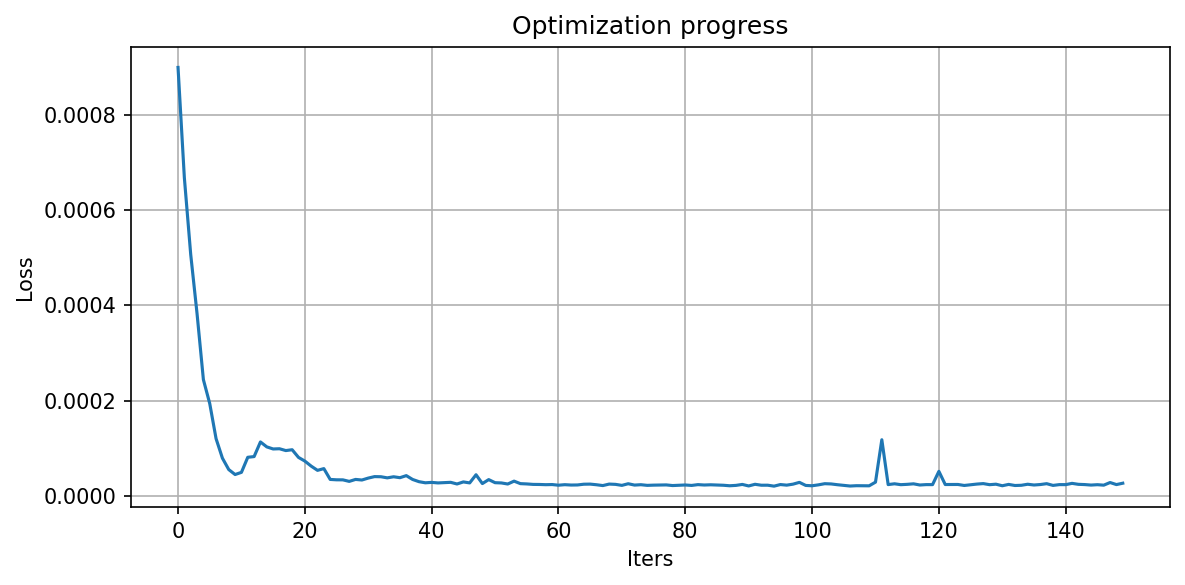

In [10]:
plt.figure(figsize=(8,4), dpi=150)
plt.title("Optimization progress")
plt.plot(np.array(losses))
plt.xlabel("Iters")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()
plt.savefig("./output/loss.png")

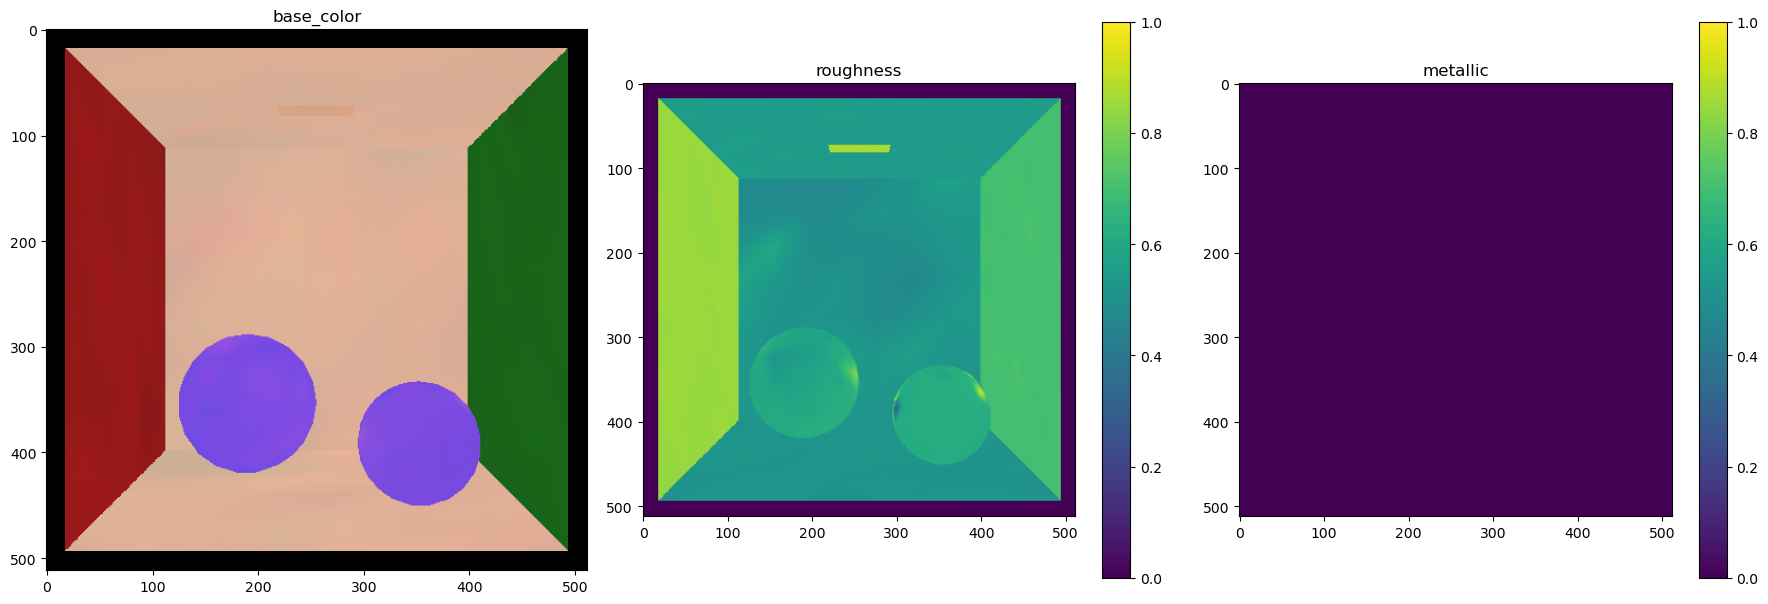

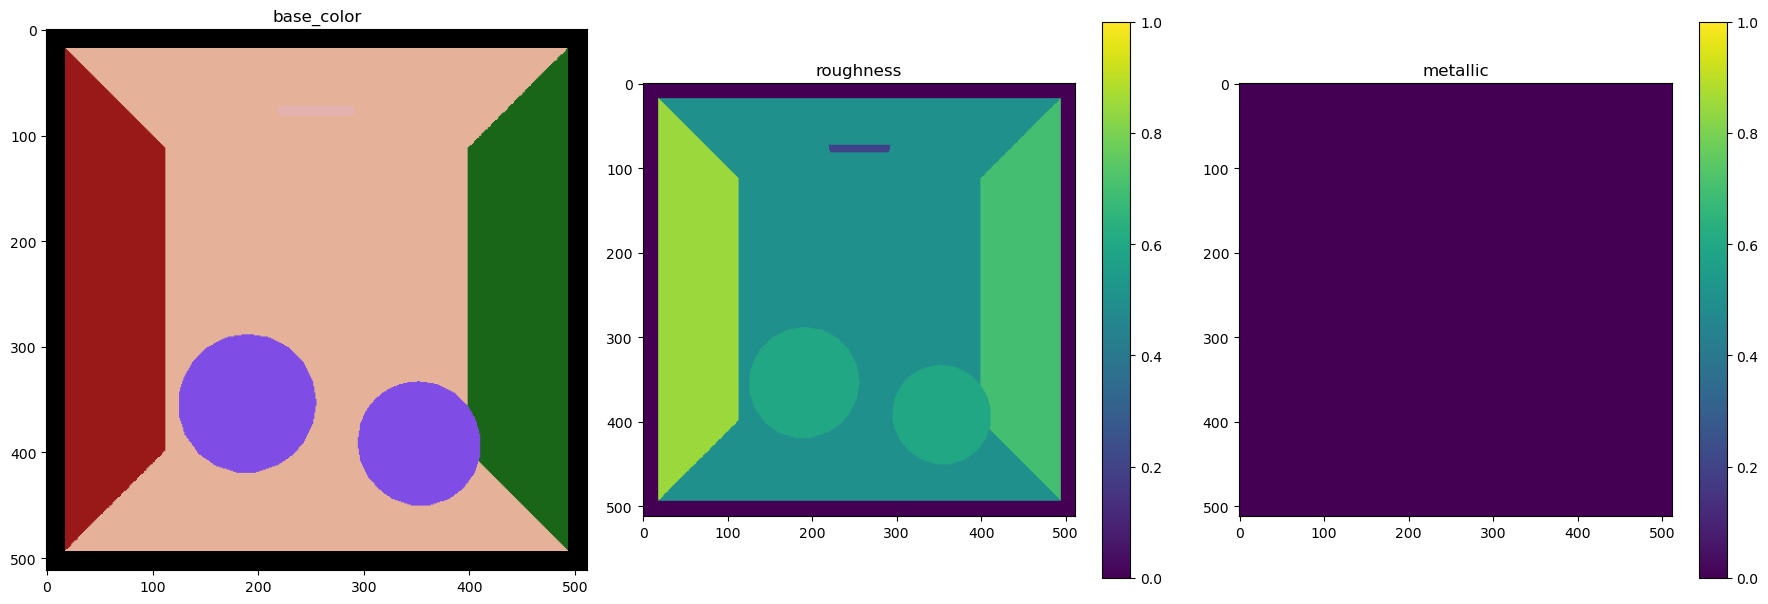

In [11]:
out = render_attributes(scene, (512,512), True, "output/final")

# BSDF final values
plt.figure(figsize=(18,6), dpi=100)
plt.subplot(131); plt.imshow(out[:,:,:3]); plt.title("base_color")
plt.subplot(132); plt.imshow(out[:,:,3], vmin=0.0, vmax=1.0); plt.title("roughness"); plt.colorbar()
plt.subplot(133); plt.imshow(out[:,:,4], vmin=0.0, vmax=1.0); plt.title("metallic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,5], vmin=0.0, vmax=1.0); plt.title("anisotropic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,6], vmin=0.0, vmax=1.0); plt.title("spec_tint");  plt.colorbar()
plt.tight_layout()
plt.savefig("output/final.png")

out_gt = render_attributes_gt(scene, (512,512), True, "output/reference")

# BSDF final values
plt.figure(figsize=(18,6), dpi=100)
plt.subplot(131); plt.imshow(out_gt[:,:,:3]); plt.title("base_color")
plt.subplot(132); plt.imshow(out_gt[:,:,3], vmin=0.0, vmax=1.0); plt.title("roughness"); plt.colorbar()
plt.subplot(133); plt.imshow(out_gt[:,:,4], vmin=0.0, vmax=1.0); plt.title("metallic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out_gt[:,:,5], vmin=0.0, vmax=1.0); plt.title("anisotropic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out_gt[:,:,6], vmin=0.0, vmax=1.0); plt.title("spec_tint");  plt.colorbar()
plt.tight_layout()
plt.savefig("output/reference.png")

In [12]:
ps_visualize_textures(scene)

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 550.120
